# DeFi analysis using On-chain activity, sentiment analysis (twitter/X) and price & action

This research would answer the following questions

1. Which On-chain metric has the most influence on the price movements.
2. How can data science approach improve DeFi insights.
3. Is social media sentiment a reliable factor. And which sentiment factor has the most influence on the volatility.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import requests
import json
import time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection
The datasets of Bitcoin Blockchain data, news and price & action data has been imported into the form of Dataframe

# Bitcoin blockchain historical data

Jesus Graterol. (2023). Bitcoin Blockchain Historical Data [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/6622981

LICENSE: CC0: Public Domain https://creativecommons.org/publicdomain/zero/1.0/

In [ ]:
chain_df = pd.read_csv("/content/dataset.csv") #Blockchain data

#Bitcoin news sentiment dataset

Data source: Kaggle https://www.kaggle.com/datasets/imadallal/sentiment-analysis-of-bitcoin-news-2021-2024

LICENSE: MIT  https://www.mit.edu/~amini/LICENSE.md

In [ ]:
news_df = pd.read_csv("/content/bitcoint_news.csv") # News data for sentiment analysis

# Bitcoin Price & Action hourly dataset

Data source: Kaggle https://www.kaggle.com/datasets/franoisgeorgesjulien/crypto

LICENSE: CC0: Public Domain https://creativecommons.org/publicdomain/zero/1.0/

In [ ]:
price_df = pd.read_csv("/content/Binance_BTCUSDT_1h (1).csv") # Price and action data

# Data Pre-processing

# Bitcoin on-chain data

In [ ]:
chain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810909 entries, 0 to 810908
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   height           810909 non-null  int64  
 1   timestamp        810909 non-null  int64  
 2   size             810909 non-null  int64  
 3   tx_count         810909 non-null  int64  
 4   difficulty       810909 non-null  float64
 5   median_fee_rate  810909 non-null  float64
 6   avg_fee_rate     810909 non-null  int64  
 7   total_fees       810909 non-null  int64  
 8   fee_range_min    810909 non-null  float64
 9   fee_range_max    810909 non-null  float64
 10  input_count      810909 non-null  int64  
 11  output_count     810909 non-null  int64  
 12  output_amount    810909 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 80.4 MB


In [ ]:
chain_df.head()

,height,timestamp,size,tx_count,difficulty,median_fee_rate,avg_fee_rate,total_fees,fee_range_min,fee_range_max,input_count,output_count,output_amount
0,1,1231469665000,215,1,1.0,0.0,0,0,0.0,0.0,0,1,0
1,2,1231469744000,215,1,1.0,0.0,0,0,0.0,0.0,0,1,0
2,3,1231470173000,215,1,1.0,0.0,0,0,0.0,0.0,0,1,0
3,4,1231470988000,215,1,1.0,0.0,0,0,0.0,0.0,0,1,0
4,5,1231471428000,215,1,1.0,0.0,0,0,0.0,0.0,0,1,0


**Unix to Epoc timestamp**
In the dataset the timestamps are in the Unix format therefore needs to be converted in Epoch format (Human readable)

In [ ]:
chain_df['timestamp'] = pd.to_datetime(chain_df['timestamp'], unit='ms') #Unit = ms as its in the milliseconds

In [ ]:
#filtering out the data before 05-11-2021 to align with other features
chain_df = chain_df[chain_df['timestamp'] >= '2021-11-05']

In [ ]:
chain_df =  chain_df.reset_index()
chain_df.drop('index', axis=1, inplace=True)

In [ ]:
chain_df.head()

,height,timestamp,size,tx_count,difficulty,median_fee_rate,avg_fee_rate,total_fees,fee_range_min,fee_range_max,input_count,output_count,output_amount
0,708244,2021-11-05 00:12:15,1324780,1811,2.165934e+13,9.0,14,14017519,1.0,511.0,6517,7397,927678770734
1,708245,2021-11-05 00:32:04,1462226,2804,2.165934e+13,10.0,13,13496437,1.0,382.0,6640,9892,4418819610436
2,708246,2021-11-05 00:37:37,942533,2007,2.165934e+13,2.0,7,4679079,1.0,392.0,4081,5495,3010507070944
3,708247,2021-11-05 00:46:51,869480,1490,2.165934e+13,9.0,11,6313550,1.0,261.0,3806,4842,1519934682149
4,708248,2021-11-05 00:48:46,149257,327,2.165934e+13,9.0,14,1438763,1.0,349.0,629,1185,2342685323918


In [ ]:
chain_df = chain_df.loc[:, (chain_df != chain_df.iloc[0]).any()]

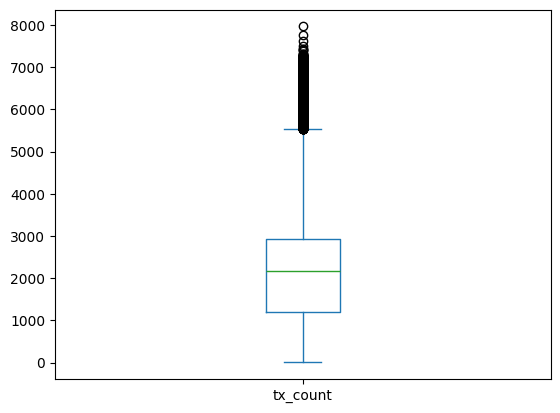

In [ ]:
chain_df['tx_count'].plot(kind='box')
plt.show()


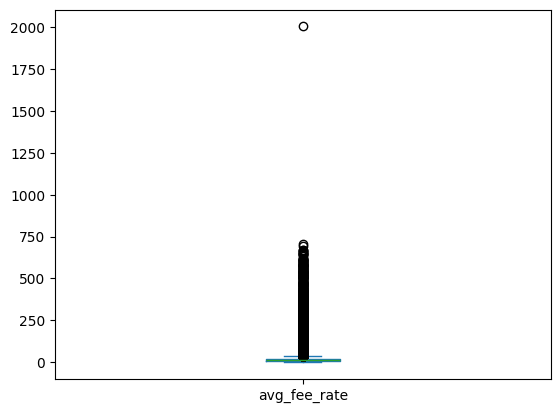

In [ ]:
chain_df['avg_fee_rate'].plot(kind='box')
plt.show()

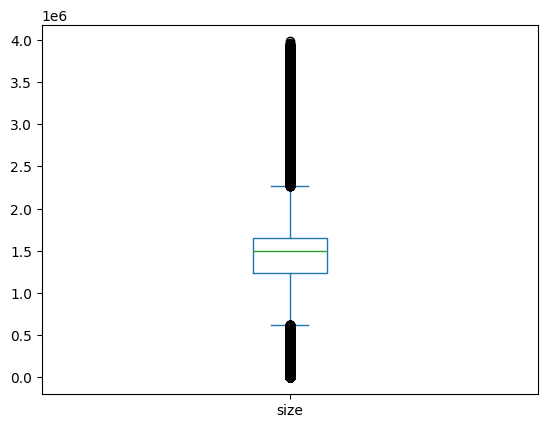

In [ ]:
chain_df['size'].plot(kind='box')
plt.show()

In [ ]:
chain_df['tx_count_rolling'] = chain_df['tx_count'].rolling(window=24).mean() #24H moving average

In [ ]:
# Set the 'timestamp' column as the index before resampling
chain_df = chain_df.set_index('timestamp')

# Resampling data to hourly frequency, forward filling missing data
chain_hourly = chain_df.resample('H').mean()

# Forward fill if needed
chain_hourly = chain_hourly.ffill()

# Preview
chain_hourly.head()

<ipython-input-16-afceec881096>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  chain_hourly = chain_df.resample('H').mean()


,height,size,tx_count,difficulty,median_fee_rate,avg_fee_rate,total_fees,fee_range_min,fee_range_max,input_count,output_count,output_amount,tx_count_rolling
timestamp,,,,,,,,,,,,,
2021-11-05 00:00:00,708247.5,6.930569e+05,1233.375000,2.165934e+13,8.625000,12.25,5955237.75,1.0,309.125000,3156.500000,4230.625000,2.224711e+12,NaN
2021-11-05 01:00:00,708254.5,7.774625e+05,1364.166667,2.165934e+13,9.166667,13.50,6879084.00,1.0,384.333333,3444.833333,4917.333333,2.849480e+12,NaN
2021-11-05 02:00:00,708260.5,1.508446e+06,1441.166667,2.165934e+13,4.333333,9.00,8205265.00,1.0,401.500000,6043.666667,5409.333333,2.189159e+12,NaN
2021-11-05 03:00:00,708266.0,8.909664e+05,1161.600000,2.165934e+13,7.000000,12.20,9365626.60,0.8,366.200000,3567.200000,7739.600000,3.111632e+12,1298.270833
2021-11-05 04:00:00,708272.0,8.826056e+05,1138.428571,2.165934e+13,7.857143,12.00,8956916.00,1.0,350.142857,4236.285714,4575.000000,2.857010e+12,1215.535714


In [ ]:
scaler = MinMaxScaler()


cols_to_scale = chain_hourly.select_dtypes(include='number').columns

chain_scaled = pd.DataFrame(
    scaler.fit_transform(chain_hourly[cols_to_scale]),
    columns=cols_to_scale,
    index=chain_hourly.index
)

# Preview
chain_scaled.head()

,height,size,tx_count,difficulty,median_fee_rate,avg_fee_rate,total_fees,fee_range_min,fee_range_max,input_count,output_count,output_amount,tx_count_rolling
timestamp,,,,,,,,,,,,,
2021-11-05 00:00:00,0.000000,0.145237,0.158185,0.0,0.012645,0.013314,0.007066,0.001816,6.715850e-15,0.185202,0.187421,0.034237,NaN
2021-11-05 01:00:00,0.000068,0.173812,0.182827,0.0,0.013543,0.015201,0.008455,0.001816,9.840910e-15,0.212350,0.228893,0.043998,NaN
2021-11-05 02:00:00,0.000127,0.421286,0.197335,0.0,0.005528,0.008409,0.010449,0.001816,1.055422e-14,0.457046,0.258606,0.033682,NaN
2021-11-05 03:00:00,0.000180,0.212239,0.144661,0.0,0.009950,0.013238,0.012194,0.001453,9.087433e-15,0.223872,0.399338,0.048094,0.166476
2021-11-05 04:00:00,0.000239,0.209408,0.140296,0.0,0.011372,0.012937,0.011579,0.001816,8.420226e-15,0.286870,0.208219,0.044116,0.148924


# News data for sentiment analysis

Import NLTK libraries to pre-processs sentiment data

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11295 entries, 0 to 11294
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 11295 non-null  object 
 1   Short Description    11295 non-null  object 
 2   Accurate Sentiments  11295 non-null  float64
dtypes: float64(1), object(2)
memory usage: 264.9+ KB


In [ ]:
news_df.head()

,Date,Short Description,Accurate Sentiments
0,2021-11-05 04:42:00,Bitcoin price is consolidating near the USD 62...,0.998558
1,2021-11-05 08:15:00,Congress could finally approve or reject the m...,0.000000
2,2021-11-05 10:24:00,Bitcoin increasingly becoming a political inst...,0.000000
3,2021-11-05 16:58:00,There is still potential for the price of bitc...,0.999458
4,2021-11-05 21:00:00,'Several companies' are looking to Latin Ameri...,0.000000


In [ ]:
news_df['Date'] = news_df['Date'].astype('datetime64[ns]')

In [ ]:
news_df = news_df[news_df['Date'] <= '2023-10-06']

In [ ]:
# Function to clean the text

def clean_text(text):
    # Removing the URLs form text (if any)

    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove  special characters and digits
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Convert them to lowercase
    text = text.lower()
    return text

# Apply the cleaning function to the 'Short Description' column
news_df['Cleaned Description'] = news_df['Short Description'].apply(clean_text)

In [ ]:
news_df[['Short Description', 'Cleaned Description']].head()

,Short Description,Cleaned Description
0,Bitcoin price is consolidating near the USD 62...,bitcoin price is consolidating near the usd s...
1,Congress could finally approve or reject the m...,congress could finally approve or reject the m...
2,Bitcoin increasingly becoming a political inst...,bitcoin increasingly becoming a political inst...
3,There is still potential for the price of bitc...,there is still potential for the price of bitc...
4,'Several companies' are looking to Latin Ameri...,several companies are looking to latin america...


**Tokenization and removing stop words**

This step splits texts into words and remove stop words that does not make any meaning

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
# Tokenization function

def tokenize_and_remove_stopwords(text):
    # Tokenize text into words

    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

# Apply the tokenization and stopword removal to the cleaned descriptions
news_df['Processed Description'] = news_df['Cleaned Description'].apply(tokenize_and_remove_stopwords)


In [ ]:
news_df[['Cleaned Description', 'Processed Description']].head()

,Cleaned Description,Processed Description
0,bitcoin price is consolidating near the usd s...,bitcoin price consolidating near usd support e...
1,congress could finally approve or reject the m...,congress could finally approve reject muchmali...
2,bitcoin increasingly becoming a political inst...,bitcoin increasingly becoming political instru...
3,there is still potential for the price of bitc...,still potential price bitcoin rise top market ...
4,several companies are looking to latin america...,several companies looking latin america set cr...


In [ ]:
news_df = news_df.drop(columns=['Short Description', 'Accurate Sentiments'])

In [ ]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
analyzer = SentimentIntensityAnalyzer()

# Applying sentiment analysis
def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound']  # compound score is between -1 to 1

# Generate sentiment column
news_df['Generated Sentiment'] = news_df['Processed Description'].apply(get_sentiment)

In [ ]:
news_df.head()

,Date,Cleaned Description,Processed Description,Generated Sentiment
0,2021-11-05 04:42:00,bitcoin price is consolidating near the usd s...,bitcoin price consolidating near usd support e...,0.4404
1,2021-11-05 08:15:00,congress could finally approve or reject the m...,congress could finally approve reject muchmali...,-0.4019
2,2021-11-05 10:24:00,bitcoin increasingly becoming a political inst...,bitcoin increasingly becoming political instru...,0.4019
3,2021-11-05 16:58:00,there is still potential for the price of bitc...,still potential price bitcoin rise top market ...,0.3612
4,2021-11-05 21:00:00,several companies are looking to latin america...,several companies looking latin america set cr...,0.2732


# Price & Action data

In [ ]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53988 entries, 0 to 53987
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         53988 non-null  object 
 1   Symbol       53988 non-null  object 
 2   Open         53988 non-null  float64
 3   High         53988 non-null  float64
 4   Low          53988 non-null  float64
 5   Close        53988 non-null  float64
 6   Volume BTC   53988 non-null  float64
 7   Volume USDT  53988 non-null  float64
 8   tradecount   53988 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 3.7+ MB


In [ ]:
price_df.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,2023-10-19 23:00:00,BTCUSDT,28649.64,28717.82,28630.19,28713.71,613.28448,1.758298e+07,27099
1,2023-10-19 22:00:00,BTCUSDT,28604.09,28704.99,28598.60,28649.65,767.85518,2.200420e+07,28479
2,2023-10-19 21:00:00,BTCUSDT,28715.39,28739.73,28604.09,28604.09,1118.51697,3.205666e+07,42623
3,2023-10-19 20:00:00,BTCUSDT,28750.75,28882.07,28684.80,28715.38,1737.14711,4.997623e+07,59830
4,2023-10-19 19:00:00,BTCUSDT,28646.98,28765.76,28645.00,28750.75,1039.20935,2.984059e+07,49985


In [ ]:
price_df.tail()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
53983,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4239.503586,28
53984,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,19241.058300,25
53985,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,31282.312670,36
53986,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,100304.823567,102
53987,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,202366.138393,171


In [ ]:
#Converting the column date as datetime datatype
price_df['Date'] = price_df['Date'].astype('datetime64[ns]')

In [ ]:
#Dropping the rows before 05-11-2021 and after 06-10-2023
price_df = price_df[price_df['Date'] >= '2021-11-05']
price_df = price_df[price_df['Date'] <= '2023-10-06']

In [ ]:
price_df = price_df.sort_values(by='Date', ascending=True).reset_index(drop=True)

In [ ]:
price_df.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,2021-11-05 00:00:00,BTCUSDT,61395.01,61489.99,60820.00,60873.95,1198.06029,7.328003e+07,48764
1,2021-11-05 01:00:00,BTCUSDT,60873.96,61810.51,60846.79,61784.72,1281.06730,7.862917e+07,46710
2,2021-11-05 02:00:00,BTCUSDT,61784.00,61930.85,61620.45,61624.99,1366.45302,8.442206e+07,43047
3,2021-11-05 03:00:00,BTCUSDT,61624.99,62332.04,61624.99,62203.80,1556.07190,9.658727e+07,56029
4,2021-11-05 04:00:00,BTCUSDT,62203.79,62375.00,62064.42,62088.02,1353.54411,8.415231e+07,44791


In [ ]:
# Set 'Date' as index for time-series operations
price_df.set_index('Date', inplace=True)

# Check for missing time intervals
time_diff = price_df.index.to_series().diff().dropna()
missing_times = time_diff[time_diff != pd.Timedelta('1 hour')]

In [ ]:
# Display any missing intervals
if not missing_times.empty:
    print(f"Missing time intervals found: \n{missing_times}")
else:
    print("No missing time intervals.")

Missing time intervals found: 
Date
2023-03-24 14:00:00   0 days 02:00:00
Name: Date, dtype: timedelta64[ns]


In [ ]:
# Resample data to hourly frequency, forward filling missing data
price_df = price_df.resample('H').ffill()

# Display the resampled data
price_df.head()


<ipython-input-42-63c8e202b9da>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_df = price_df.resample('H').ffill()


,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
Date,,,,,,,,
2021-11-05 00:00:00,BTCUSDT,61395.01,61489.99,60820.00,60873.95,1198.06029,7.328003e+07,48764
2021-11-05 01:00:00,BTCUSDT,60873.96,61810.51,60846.79,61784.72,1281.06730,7.862917e+07,46710
2021-11-05 02:00:00,BTCUSDT,61784.00,61930.85,61620.45,61624.99,1366.45302,8.442206e+07,43047
2021-11-05 03:00:00,BTCUSDT,61624.99,62332.04,61624.99,62203.80,1556.07190,9.658727e+07,56029
2021-11-05 04:00:00,BTCUSDT,62203.79,62375.00,62064.42,62088.02,1353.54411,8.415231e+07,44791


In [ ]:
# Initialize the MinMaxScaler


# Define columns to scale
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume BTC', 'Volume USDT', 'tradecount']

# Apply MinMax scalinga
price_data_scaled = price_df[columns_to_scale].copy()
price_data_scaled = pd.DataFrame(scaler.fit_transform(price_data_scaled), columns=columns_to_scale, index=price_df.index)

In [ ]:
price_data_scaled.head()

,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
Date,,,,,,,
2021-11-05 00:00:00,0.863360,0.858914,0.855948,0.853546,0.008732,0.024381,0.033815
2021-11-05 01:00:00,0.853527,0.864935,0.856454,0.870736,0.009337,0.026161,0.032390
2021-11-05 02:00:00,0.870702,0.867196,0.871058,0.867721,0.009959,0.028088,0.029850
2021-11-05 03:00:00,0.867701,0.874733,0.871143,0.878645,0.011341,0.032135,0.038852
2021-11-05 04:00:00,0.878624,0.875540,0.879438,0.876460,0.009865,0.027998,0.031060


In [ ]:
# Calculate percentage change in the 'Close' price
price_df['Price Change'] = price_df['Close'].pct_change() * 100

In [ ]:
# Create a moving average (e.g., 24-hour moving average of 'Close' price)
price_df['Moving Average (24h)'] = price_df['Close'].rolling(window=24).mean()

In [ ]:
price_df[['Close', 'Price Change', 'Moving Average (24h)']].tail()

,Close,Price Change,Moving Average (24h)
Date,,,
2023-10-05 20:00:00,27472.65,0.004987,27670.540000
2023-10-05 21:00:00,27450.00,-0.082446,27660.682083
2023-10-05 22:00:00,27435.26,-0.053698,27647.453333
2023-10-05 23:00:00,27410.39,-0.090650,27632.112500
2023-10-06 00:00:00,27457.17,0.170665,27617.337083


In [ ]:
# Resampling to daily data, aggregating by mean for prices and volume
price_data_daily = price_df.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume BTC': 'sum',
    'Volume USDT': 'sum',
    'tradecount': 'sum'
})

price_data_daily.head()


,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
Date,,,,,,,
2021-11-05,61395.01,62595.72,60721.00,60937.12,31604.487490,1.943346e+09,1243074
2021-11-06,60940.18,61560.49,60050.00,61470.61,25590.574080,1.556775e+09,965309
2021-11-07,61470.62,63286.35,61322.78,63273.59,25515.688300,1.585745e+09,1068629
2021-11-08,63273.58,67789.00,63273.58,67525.83,54442.094554,3.575716e+09,2349581
2021-11-09,67525.82,68524.25,66222.40,66947.66,44661.378068,3.014327e+09,1847655


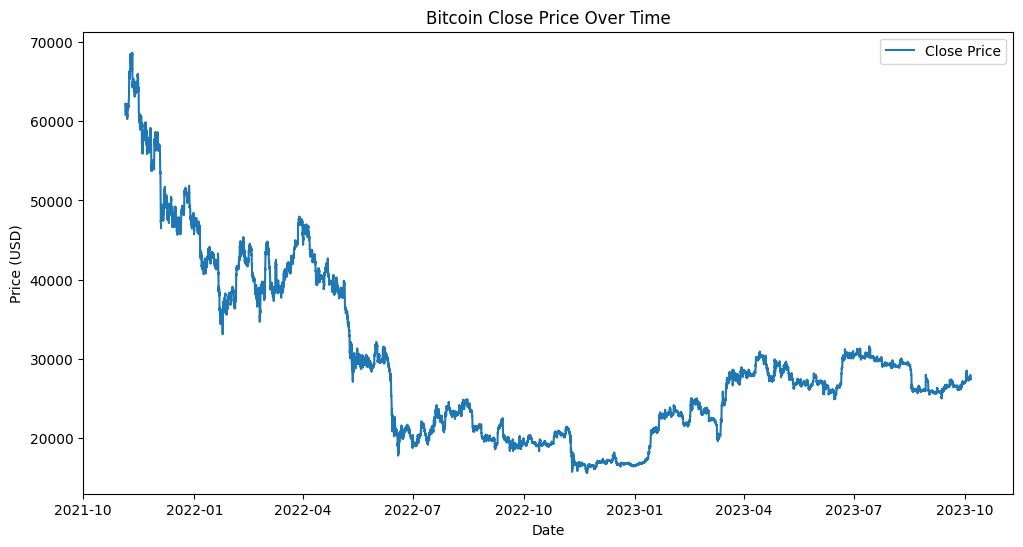

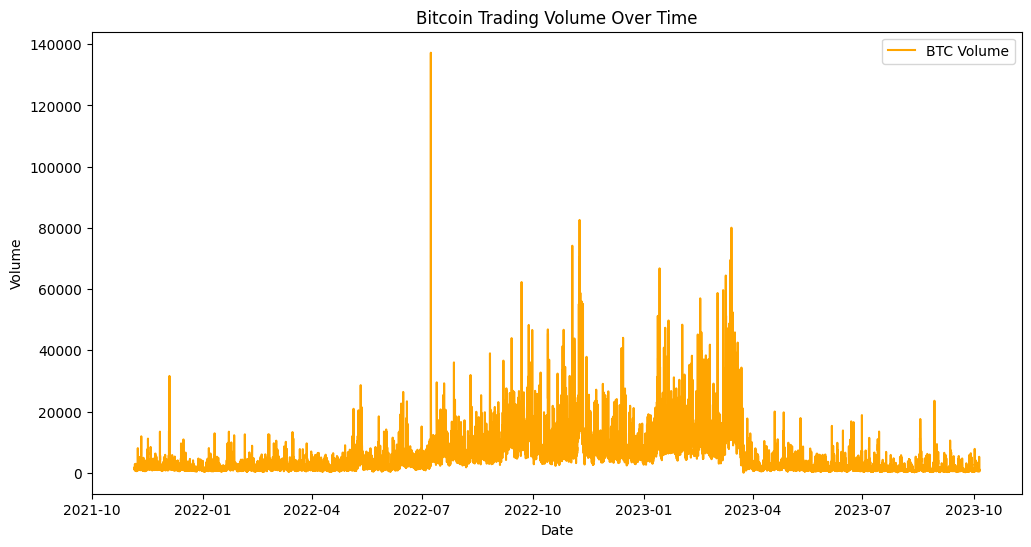

In [ ]:
# Ploting Close Price over time
plt.figure(figsize=(12, 6))
plt.plot(price_df['Close'], label='Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot by  Volume over time
plt.figure(figsize=(12, 6))
plt.plot(price_df['Volume BTC'], label='BTC Volume', color='orange')
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


# Merging all dataframes by date and time


In [ ]:
price_df.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,Price Change,Moving Average (24h)
Date,,,,,,,,,,
2021-11-05 00:00:00,BTCUSDT,61395.01,61489.99,60820.00,60873.95,1198.06029,7.328003e+07,48764,NaN,NaN
2021-11-05 01:00:00,BTCUSDT,60873.96,61810.51,60846.79,61784.72,1281.06730,7.862917e+07,46710,1.496157,NaN
2021-11-05 02:00:00,BTCUSDT,61784.00,61930.85,61620.45,61624.99,1366.45302,8.442206e+07,43047,-0.258527,NaN
2021-11-05 03:00:00,BTCUSDT,61624.99,62332.04,61624.99,62203.80,1556.07190,9.658727e+07,56029,0.939246,NaN
2021-11-05 04:00:00,BTCUSDT,62203.79,62375.00,62064.42,62088.02,1353.54411,8.415231e+07,44791,-0.186130,NaN


In [ ]:
# News Data
if 'Date' in news_df.columns:
    news_df['Date'] = pd.to_datetime(news_df['Date'])
    news_df.set_index('Date', inplace=True)
else:
    news_df.index = pd.to_datetime(news_df.index)

price_df.index = pd.to_datetime(price_df.index)





In [ ]:
# On-chain Data makeing datetime from timestamp
if 'timestamp' in chain_df.columns:
    chain_df['datetime'] = pd.to_datetime(chain_df['timestamp'], unit='ms')
    chain_df.set_index('datetime', inplace=True)
else:
    chain_df.index = pd.to_datetime(chain_df.index)

In [ ]:
# aligning all to hourly frequency
news_df.index = news_df.index.floor('H')
price_df.index = price_df.index.floor('H')
chain_df.index = chain_df.index.floor('H')

<ipython-input-53-71e25d2aa5bf>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  news_df.index = news_df.index.floor('H')
<ipython-input-53-71e25d2aa5bf>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_df.index = price_df.index.floor('H')
<ipython-input-53-71e25d2aa5bf>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  chain_df.index = chain_df.index.floor('H')


In [ ]:
news_df.index = pd.to_datetime(news_df.index).floor('H')
price_df.index = pd.to_datetime(price_df.index).floor('H')
chain_df.index = pd.to_datetime(chain_df.index).floor('H')

<ipython-input-54-4783aad180d8>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  news_df.index = pd.to_datetime(news_df.index).floor('H')
<ipython-input-54-4783aad180d8>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_df.index = pd.to_datetime(price_df.index).floor('H')
<ipython-input-54-4783aad180d8>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  chain_df.index = pd.to_datetime(chain_df.index).floor('H')


In [ ]:
merged_df = price_df.join(chain_df, how='inner')

In [ ]:
merged_df = merged_df.join(news_df, how='left')

In [ ]:
merged_df.sort_index(inplace=True)

In [ ]:
merged_df.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,Price Change,Moving Average (24h),...,total_fees,fee_range_min,fee_range_max,input_count,output_count,output_amount,tx_count_rolling,Cleaned Description,Processed Description,Generated Sentiment
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-05,BTCUSDT,61395.01,61489.99,60820.0,60873.95,1198.06029,7.328003e+07,48764,NaN,NaN,...,14017519,1.0,511.0,6517,7397,927678770734,NaN,NaN,NaN,NaN
2021-11-05,BTCUSDT,61395.01,61489.99,60820.0,60873.95,1198.06029,7.328003e+07,48764,NaN,NaN,...,13496437,1.0,382.0,6640,9892,4418819610436,NaN,NaN,NaN,NaN
2021-11-05,BTCUSDT,61395.01,61489.99,60820.0,60873.95,1198.06029,7.328003e+07,48764,NaN,NaN,...,4679079,1.0,392.0,4081,5495,3010507070944,NaN,NaN,NaN,NaN
2021-11-05,BTCUSDT,61395.01,61489.99,60820.0,60873.95,1198.06029,7.328003e+07,48764,NaN,NaN,...,6313550,1.0,261.0,3806,4842,1519934682149,NaN,NaN,NaN,NaN
2021-11-05,BTCUSDT,61395.01,61489.99,60820.0,60873.95,1198.06029,7.328003e+07,48764,NaN,NaN,...,1438763,1.0,349.0,629,1185,2342685323918,NaN,NaN,NaN,NaN


Checking for duplicates due to significantly high number of rows

In [ ]:
print("Price Data Timestamps:", price_df.index.nunique())
print("News Data Timestamps:", news_df.index.nunique())
print("On-Chain Data Timestamps:", chain_df.index.nunique())

Price Data Timestamps: 16801
News Data Timestamps: 6400
On-Chain Data Timestamps: 16760


In [ ]:
print("News duplicate timestamps:", news_df.index.duplicated().sum())
print("Price duplicate timestamps:", price_df.index.duplicated().sum())
print("On-Chain duplicate timestamps:", chain_df.index.duplicated().sum())

News duplicate timestamps: 2362
Price duplicate timestamps: 0
On-Chain duplicate timestamps: 85906


In [ ]:
news_df = news_df[~news_df.index.duplicated(keep='last')]

In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6400 entries, 2021-11-05 04:00:00 to 2023-10-05 22:00:00
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Cleaned Description    6400 non-null   object 
 1   Processed Description  6400 non-null   object 
 2   Generated Sentiment    6400 non-null   float64
dtypes: float64(1), object(2)
memory usage: 200.0+ KB


In [ ]:
# Resampling on-chain data to hourly using mean
chain_df_hourly = chain_df.resample('H').mean()

<ipython-input-63-0c10f54be496>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  chain_df_hourly = chain_df.resample('H').mean()


In [ ]:
price_df.index = pd.to_datetime(price_df.index)
chain_df_hourly.index = pd.to_datetime(chain_df_hourly.index)
news_df.index = pd.to_datetime(news_df.index)

In [ ]:
if isinstance(news_df, pd.Series):
    news_df = news_df.to_frame(name='last_sentiment')


In [ ]:
#Outer merging all three dataframes
merged_df = price_df \
    .merge(chain_df_hourly, left_index=True, right_index=True, how='outer') \
    .merge(news_df, left_index=True, right_index=True, how='outer')

# Step 4: Sort by datetime index
merged_df.sort_index(inplace=True)

In [ ]:
# Assume all three have datetime as index and are cleaned
merged_df = price_df \
    .merge(chain_df_hourly, left_index=True, right_index=True, how='left') \
    .merge(news_df, left_index=True, right_index=True, how='left')

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16801 entries, 2021-11-05 00:00:00 to 2023-10-06 00:00:00
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Symbol                 16801 non-null  object 
 1   Open                   16801 non-null  float64
 2   High                   16801 non-null  float64
 3   Low                    16801 non-null  float64
 4   Close                  16801 non-null  float64
 5   Volume BTC             16801 non-null  float64
 6   Volume USDT            16801 non-null  float64
 7   tradecount             16801 non-null  int64  
 8   Price Change           16800 non-null  float64
 9   Moving Average (24h)   16778 non-null  float64
 10  height                 16747 non-null  float64
 11  size                   16747 non-null  float64
 12  tx_count               16747 non-null  float64
 13  difficulty             16747 non-null  float64
 14  median_fee_rate    

# EDA: Exploratory Data Analysis

This step involves obeservation of data with viualizations in form of graphs plots and statistically

In [ ]:
merged_df.describe()

,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,Price Change,Moving Average (24h),height,...,median_fee_rate,avg_fee_rate,total_fees,fee_range_min,fee_range_max,input_count,output_count,output_amount,tx_count_rolling,Generated Sentiment
count,16801.000000,16801.000000,16801.000000,16801.000000,16801.000000,1.680100e+04,1.680100e+04,16800.000000,16778.000000,16747.000000,...,16747.000000,16747.000000,1.674700e+04,16747.000000,1.674700e+04,16747.000000,16747.000000,1.674700e+04,16744.000000,6400.000000
mean,29614.407285,29734.635076,29489.735983,29612.387226,5308.692785,1.267383e+08,1.249895e+05,-0.002925,29591.820780,759555.565682,...,14.731557,19.012157,1.834440e+07,5.770385,1.437046e+12,6086.183470,6977.517357,1.957021e+12,2152.860941,0.090781
std,10832.813355,10890.775668,10770.400911,10830.045703,6660.084344,1.414261e+08,1.378260e+05,0.602180,10797.473561,29597.654751,...,26.977834,29.366795,2.969961e+07,16.407718,1.859684e+14,1402.495118,2393.651868,2.437155e+12,784.875028,0.387162
min,15648.230000,15769.990000,15476.000000,15649.520000,0.000000,0.000000e+00,0.000000e+00,-6.988994,15850.729583,708247.500000,...,1.000000,3.428571,1.256346e+06,0.000000,1.475000e+02,1189.533333,1127.266667,3.326002e+10,513.575758,-0.946800
25%,21259.960000,21352.460000,21169.250000,21259.100000,1137.249450,3.987297e+07,3.213300e+04,-0.213187,21255.936875,734030.250000,...,5.636364,9.200000,7.587213e+06,1.000000,3.651742e+02,5342.100000,5097.637500,5.593357e+11,1560.370040,-0.077200
50%,27080.120000,27155.850000,27001.590000,27080.130000,2655.820690,8.153097e+07,5.957000e+04,0.001118,27054.372708,759611.500000,...,9.142857,12.666667,1.225679e+07,1.000000,4.746000e+02,6501.000000,6953.500000,1.086171e+12,2042.255952,0.000000
75%,36837.700000,37042.530000,36600.000000,36831.510000,7187.725680,1.628643e+08,1.841420e+05,0.213075,36932.993542,785303.500000,...,15.600000,19.600000,1.995357e+07,4.700954,6.831714e+02,7012.196429,8735.055556,2.493721e+12,2592.687500,0.401900
max,68635.120000,69000.000000,68451.190000,68633.690000,137207.188600,3.005634e+09,1.442097e+06,6.487233,67566.143333,810814.500000,...,604.000000,666.000000,6.662988e+08,550.705283,2.406620e+16,11810.200000,17685.500000,6.404064e+13,5227.125000,0.950100


In [ ]:
sns.set(style="whitegrid")

**Bitcoin price trends**

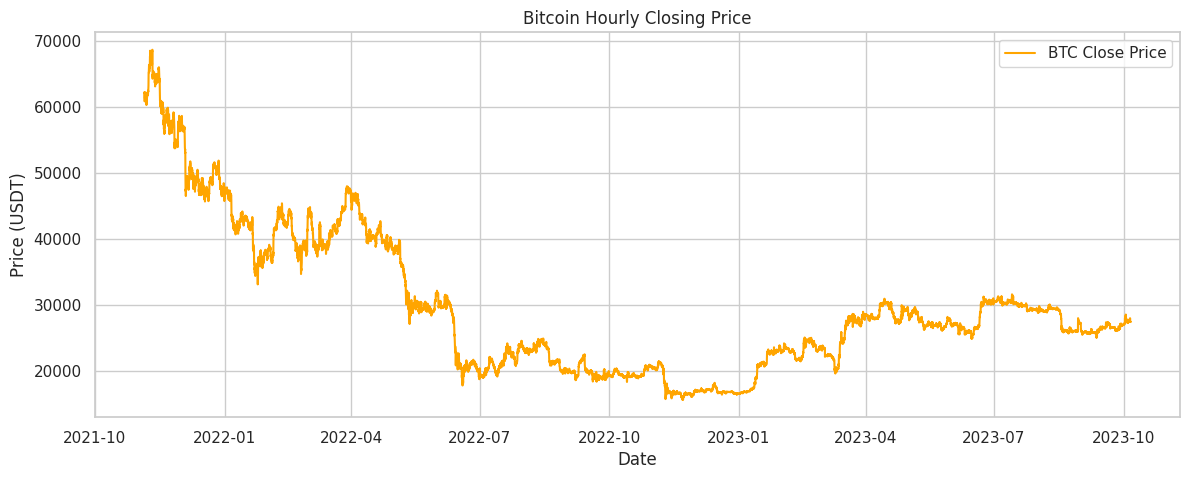

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(merged_df.index, merged_df['Close'], color='orange', label='BTC Close Price')
plt.title('Bitcoin Hourly Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()

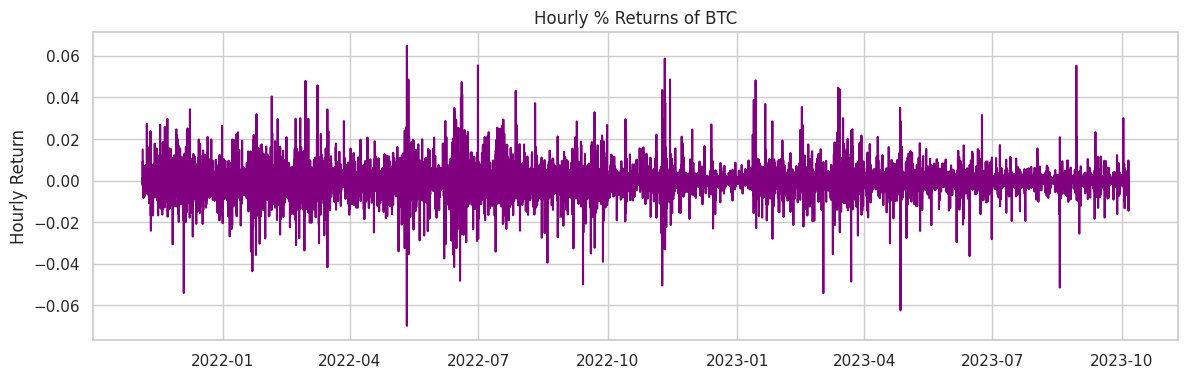

In [ ]:
merged_df['Hourly Return'] = merged_df['Close'].pct_change()

plt.figure(figsize=(14, 4))
plt.plot(merged_df.index, merged_df['Hourly Return'], color='purple')
plt.title('Hourly % Returns of BTC')
plt.ylabel('Hourly Return')
plt.show()


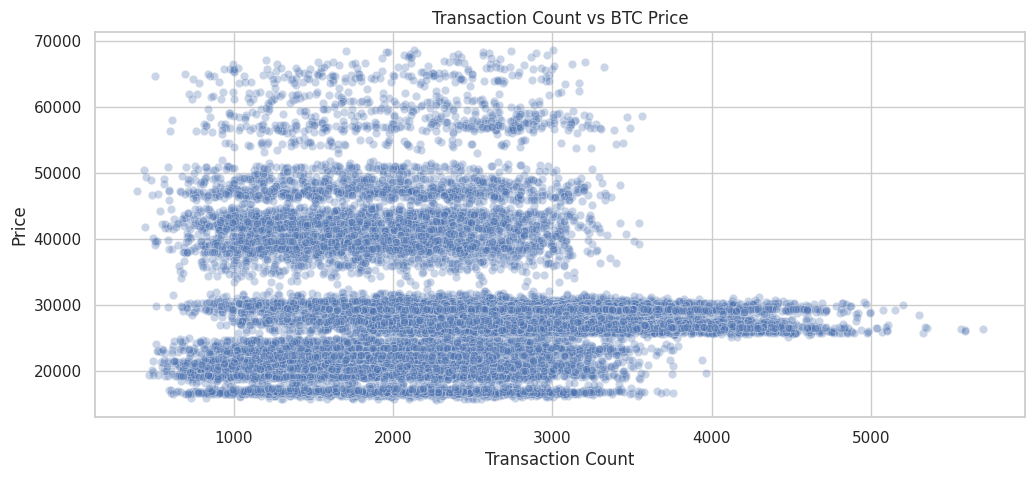

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=merged_df, x='tx_count', y='Close', alpha=0.3)
plt.title('Transaction Count vs BTC Price')
plt.xlabel('Transaction Count')
plt.ylabel('Price')
plt.show()

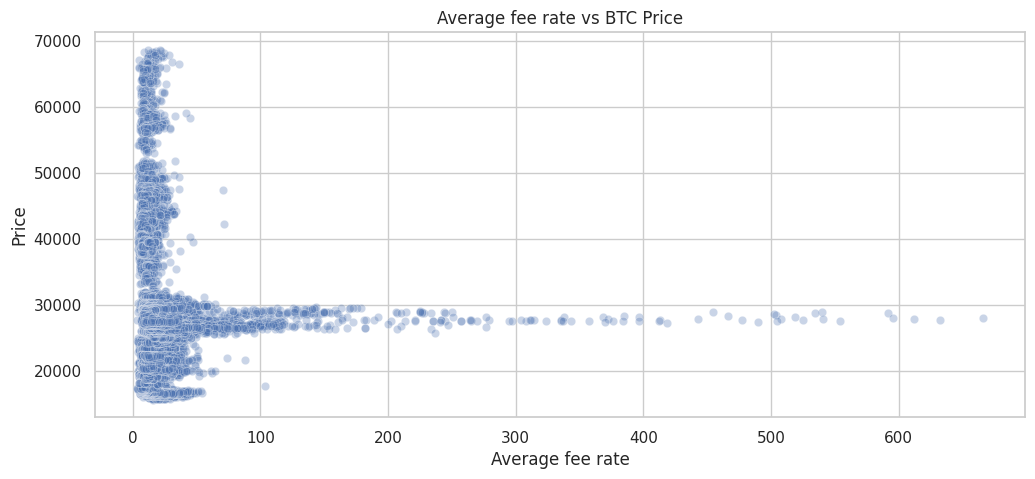

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=merged_df, x='avg_fee_rate', y='Close', alpha=0.3)
plt.title('Average fee rate vs BTC Price')
plt.xlabel('Average fee rate')
plt.ylabel('Price')
plt.show()

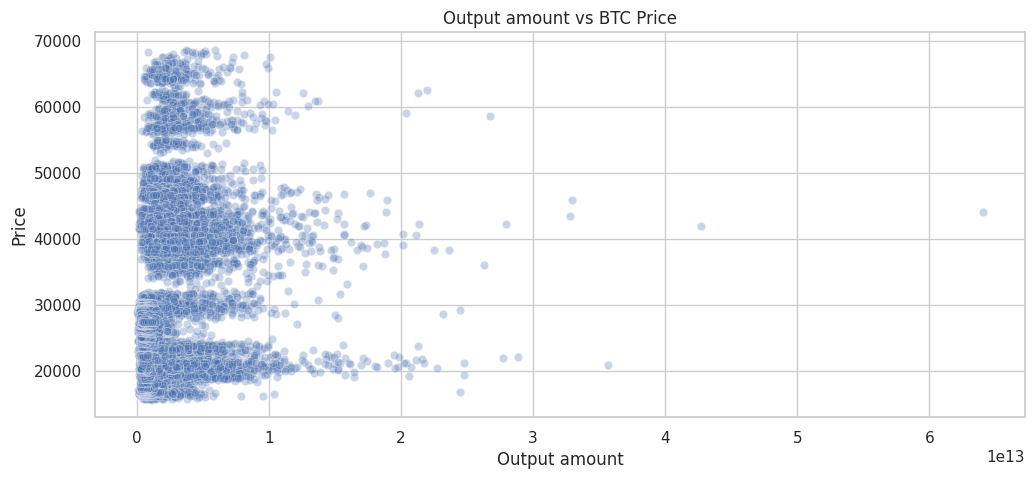

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=merged_df, x='output_amount', y='Close', alpha=0.3)
plt.title('Output amount vs BTC Price')
plt.xlabel('Output amount')
plt.ylabel('Price')
plt.show()

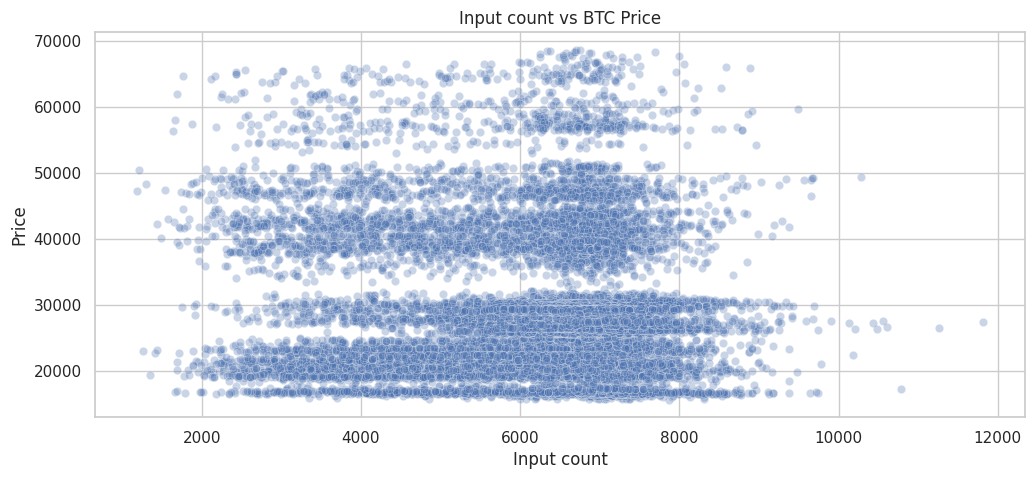

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=merged_df, x='input_count', y='Close', alpha=0.3)
plt.title('Input count vs BTC Price')
plt.xlabel('Input count')
plt.ylabel('Price')
plt.show()

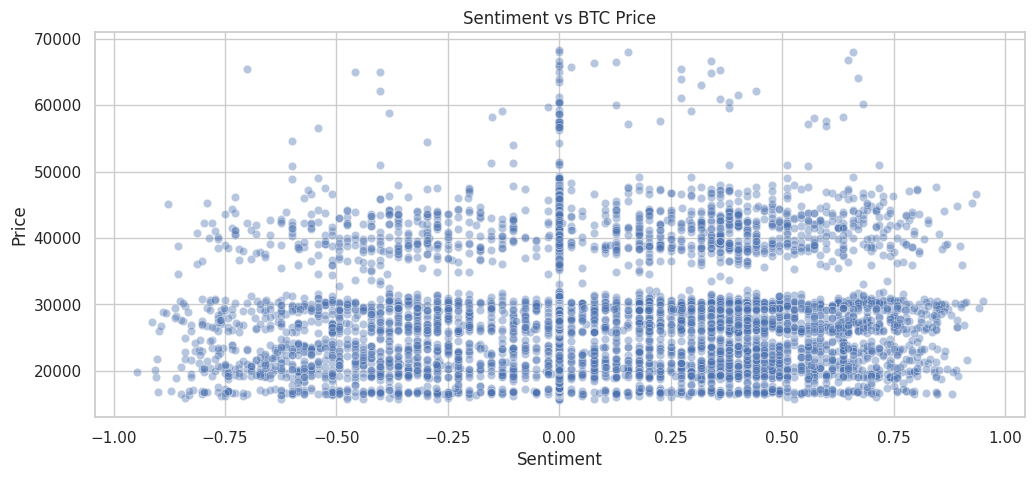

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=merged_df, x='Generated Sentiment', y='Close', alpha=0.4)
plt.title('Sentiment vs BTC Price')
plt.xlabel('Sentiment')
plt.ylabel('Price')
plt.show()

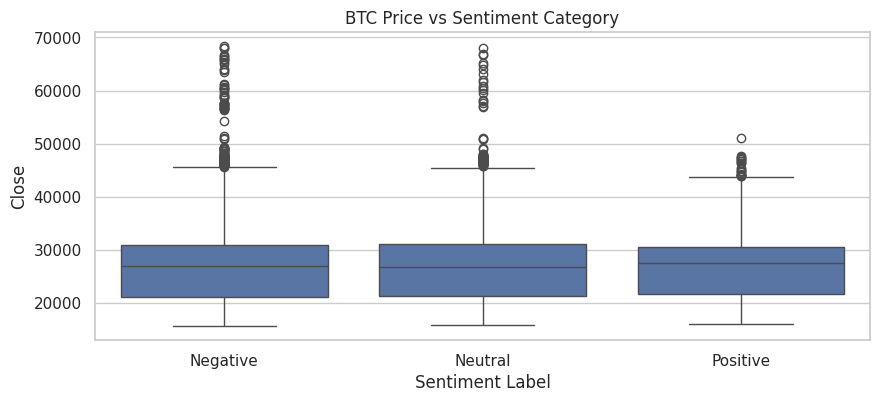

In [ ]:
# Bin sentiments
merged_df['Sentiment Label'] = pd.cut(merged_df['Generated Sentiment'], bins=[-0.1, 0.3, 0.7, 1], labels=['Negative', 'Neutral', 'Positive'])

# Boxplot of price per sentiment
plt.figure(figsize=(10, 4))
sns.boxplot(data=merged_df, x='Sentiment Label', y='Close')
plt.title('BTC Price vs Sentiment Category')
plt.show()


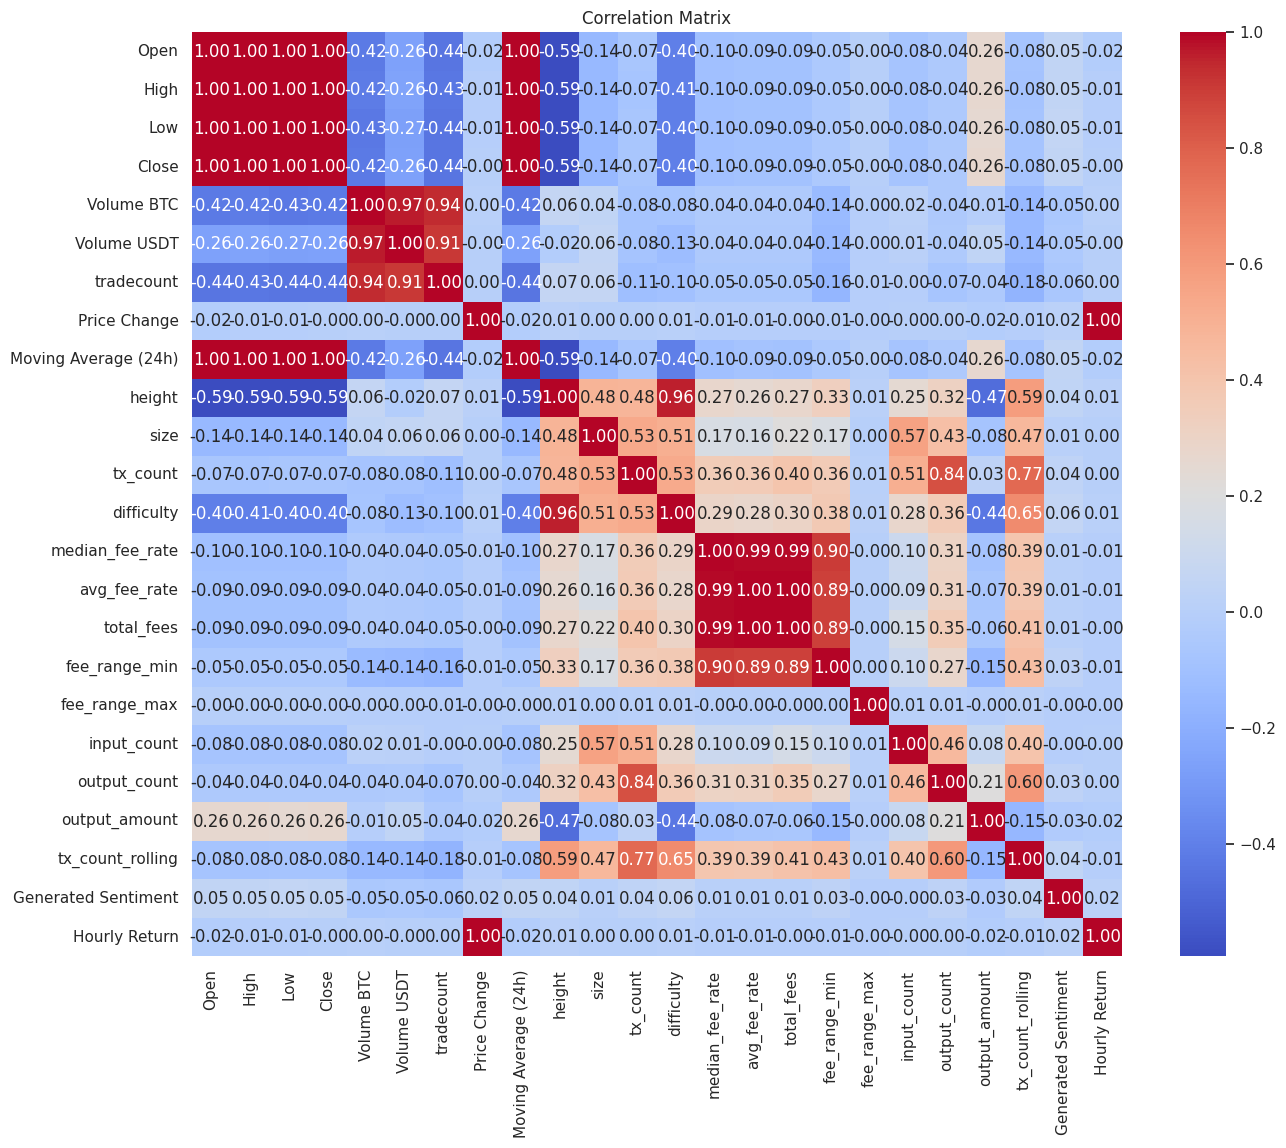

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(merged_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

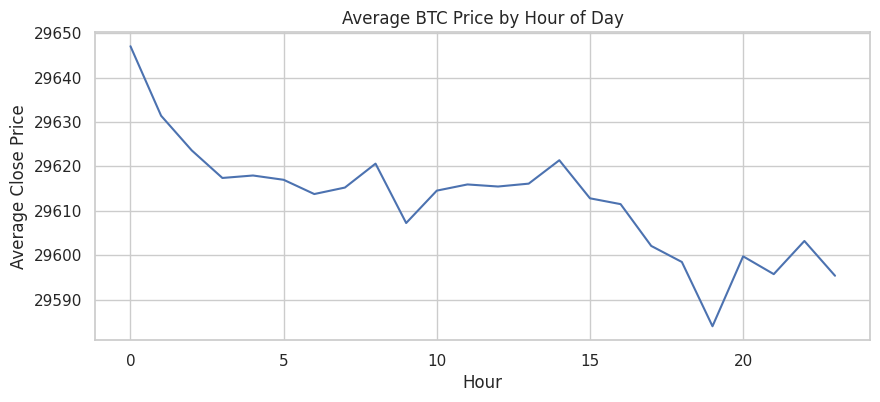

In [ ]:
merged_df['Hour'] = merged_df.index.hour
hourly_avg = merged_df.groupby('Hour')['Close'].mean()

plt.figure(figsize=(10, 4))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title('Average BTC Price by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Close Price')
plt.show()

# Time Series analysis

In [ ]:
price_df = price_df.sort_index()
ts_data = price_df[['Close']]

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_data['Close'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.987697399160823
p-value: 0.0360593908690121


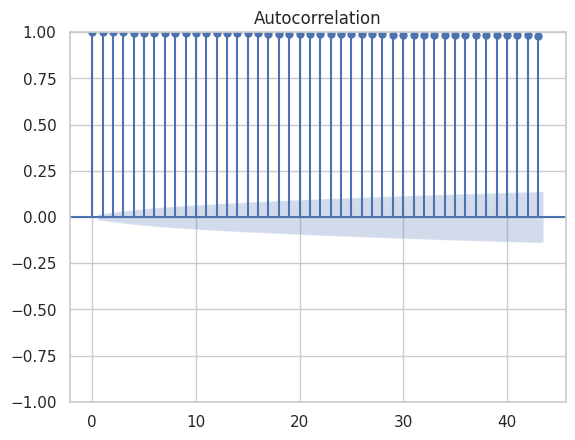

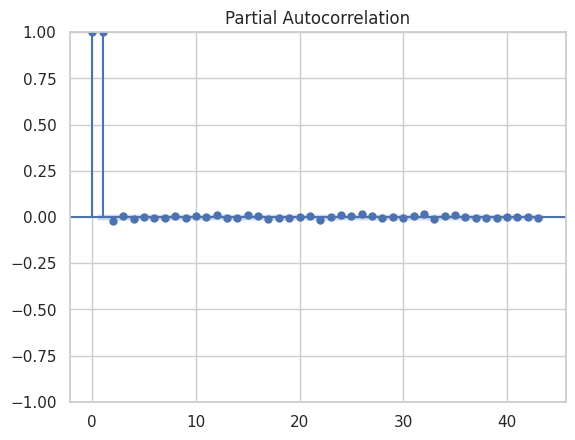

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_data['Close'])
plot_pacf(ts_data['Close'])
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_data['Close'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.987697399160823
p-value: 0.0360593908690121


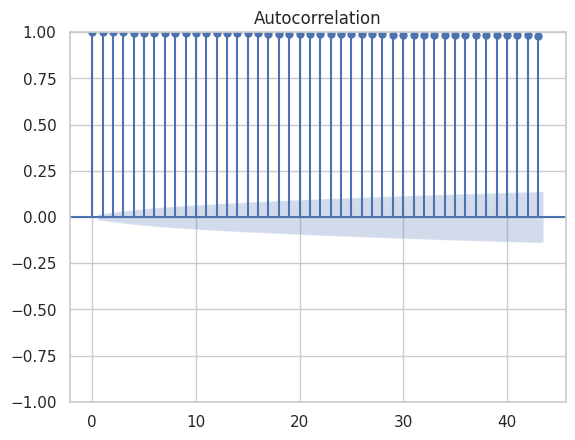

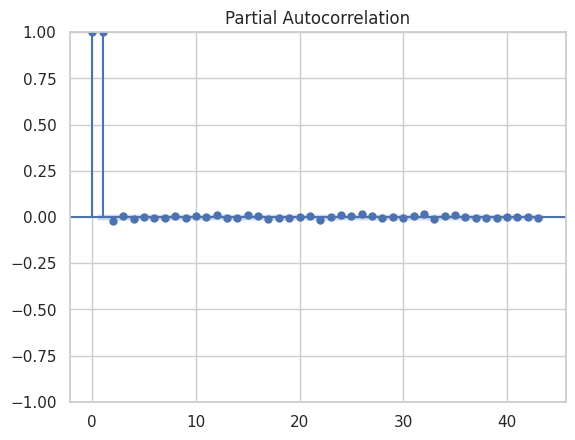

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_data['Close'])
plot_pacf(ts_data['Close'])
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts_data['Close'], order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                16801
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -112392.483
Date:                Sun, 13 Apr 2025   AIC                         224790.967
Time:                        18:51:37   BIC                         224814.154
Sample:                    11-05-2021   HQIC                        224798.618
                         - 10-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.961e+04      0.032   9.12e+05      0.000    2.96e+04    2.96e+04
ar.L1          0.9999   4.11e-05   2.43e+04      0.000       1.000       1.000
sigma2      3.783e+04    135.873    278.387      0.0

In [ ]:
predicted_values = model_fit.predict(start=0, end=len(ts_data['Close'])-1)

In [ ]:
forecast = model_fit.forecast(steps=10)

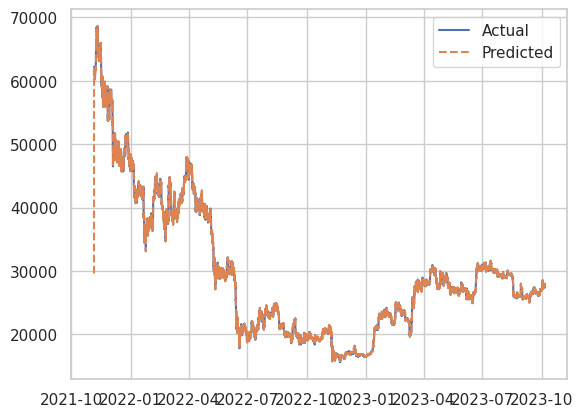

In [ ]:
# Plot actual vs predicted values
plt.plot(ts_data['Close'], label='Actual')
plt.plot(predicted_values, label='Predicted', linestyle='--')
plt.legend()
plt.show()


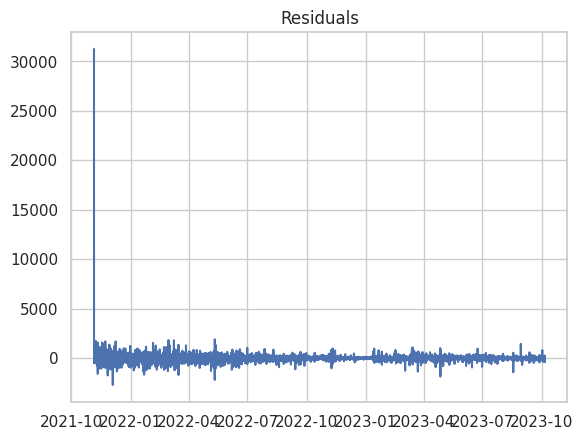

In [ ]:
residuals = ts_data['Close'] - predicted_values
plt.plot(residuals)
plt.title('Residuals')
plt.show()

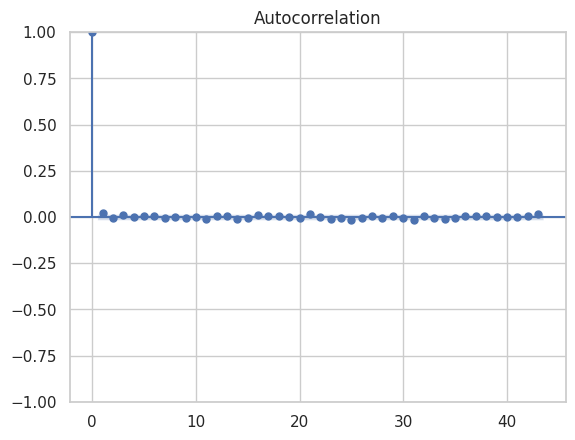

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals)
plt.show()


# Feature Engineering

In [ ]:
processed_df = merged_df.copy()


In [ ]:
num_cols = processed_df.select_dtypes(include=[np.number]).columns.tolist()
processed_df[num_cols] = processed_df[num_cols].fillna(method='ffill').fillna(0)

<ipython-input-93-07e07f4d2f62>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df[num_cols] = processed_df[num_cols].fillna(method='ffill').fillna(0)


In [ ]:
processed_df['Generated Sentiment'].fillna(0, inplace=True)

<ipython-input-94-ef83773c9e71>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['Generated Sentiment'].fillna(0, inplace=True)


In [ ]:
# For Sentiment Label, it's category and to be filled with 0
if processed_df['Sentiment Label'].dtype.name == 'category':
    processed_df['Sentiment Label'] = processed_df['Sentiment Label'].cat.add_categories([0]).fillna(0)
else:
    processed_df['Sentiment Label'].fillna(0, inplace=True)

In [ ]:
processed_df['Sentiment Label'].head()

,Sentiment Label
Date,
2021-11-05 00:00:00,0
2021-11-05 01:00:00,0
2021-11-05 02:00:00,0
2021-11-05 03:00:00,0
2021-11-05 04:00:00,Neutral


In [ ]:
processed_df['DayOfWeek'] = processed_df.index.dayofweek  # 0=Monday, 7=Sunday

In [ ]:
# adding lag features if doing supervised ML
processed_df['Close_Lag1'] = processed_df['Close'].shift(1)
processed_df['Close_Lag2'] = processed_df['Close'].shift(2)

In [ ]:
#Rolling Features
processed_df['Rolling_Mean_Close_3'] = processed_df['Close'].rolling(window=3).mean()
processed_df['Rolling_STD_Close_3'] = processed_df['Close'].rolling(window=3).std()

In [ ]:
# Filling any new NA values created by rolling/shift
processed_df.fillna(0, inplace=True)


In [ ]:
processed_df.drop(['Cleaned Description', 'Processed Description'], axis=1, inplace=True)

In [ ]:
tree_df = processed_df.copy() #for other algorithms

In [ ]:
from sklearn.preprocessing import StandardScaler

features_to_scale = processed_df.drop(columns=['Close', 'Symbol', 'Sentiment Label'])
scaler = StandardScaler()
processed_df[features_to_scale.columns] = scaler.fit_transform(features_to_scale)


In [ ]:
X = processed_df.drop(columns=['Close', 'Symbol', 'Sentiment Label'])
y = processed_df['Close']

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)  # Calculate MSE without 'squared' parameter
rmse = np.sqrt(mse)  # Calculate RMSE manually from MSE
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Linear Regression Performance:
MAE: 11.52
RMSE: 18.85
R² Score: 0.9999


# Random Forest

In [ ]:
tree_model = tree_df.dropna(subset=['Close'])

In [ ]:
X = tree_model.drop(columns=['Close', 'Symbol', 'Sentiment Label'], errors='ignore')
y = tree_model['Close']

In [ ]:
X = X.fillna(method='bfill').fillna(method='ffill') #Handling any missing values present in df

<ipython-input-110-ac9e6a1d354e>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='bfill').fillna(method='ffill') #Handling any missing values present in df


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred_rf = rf_model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

In [ ]:
print("📊 Random Forest Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

📊 Random Forest Performance:
MAE: 39.10
RMSE: 59.63
R² Score: 0.9989


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

In [ ]:
print("XGBoost Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

📊 XGBoost Performance:
MAE: 80.60
RMSE: 141.41
R² Score: 0.9937


# Hypterparameter tunning

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

param_grid_ridge = {'alpha': [0.1, 1, 10, 100, 1000]}  # alpha is the regularization strength

In [ ]:
ridge_search = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.23012e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [ ]:
best_ridge_model = ridge_search.best_estimator_
ridge_y_pred = best_ridge_model.predict(X_test)

In [ ]:
mae_ridge = mean_absolute_error(y_test, ridge_y_pred)
rmse_ridge = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2_ridge = r2_score(y_test, ridge_y_pred)

print("📊 Ridge Regression Performance:")
print(f"MAE: {mae_ridge:.2f}")
print(f"RMSE: {rmse_ridge:.2f}")
print(f"R² Score: {r2_ridge:.4f}")

📊 Ridge Regression Performance:
MAE: 1261064097.09
RMSE: 73109095960.25
R² Score: -1691150467382527.7500


In [ ]:
from sklearn.linear_model import Lasso


lasso = Lasso()

# Hyperparameter grid
param_grid_lasso = {'alpha': [0.1, 1, 10, 100, 1000]}  # alpha is the regularization strength


In [ ]:
lasso_search = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [ ]:
best_lasso_model = lasso_search.best_estimator_
lasso_y_pred = best_lasso_model.predict(X_test)

In [ ]:
mae_lasso = mean_absolute_error(y_test, lasso_y_pred)
rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso_y_pred))
r2_lasso = r2_score(y_test, lasso_y_pred)

print("Lasso Regression Performance:")
print(f"MAE: {mae_lasso:.2f}")
print(f"RMSE: {rmse_lasso:.2f}")
print(f"R² Score: {r2_lasso:.4f}")

Lasso Regression Performance:
MAE: 897872662.67
RMSE: 52053388079.45
R² Score: -857309087858158.3750


In [ ]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()

# Hyperparameter grid
param_grid_sgd = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                  'max_iter': [1000, 2000, 3000]}  # alpha is the regularization strength


In [ ]:
sgd_search = GridSearchCV(sgd, param_grid_sgd, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
sgd_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'max_iter': [1000, 2000, 3000]},
             scoring='neg_mean_squared_error')

In [ ]:
best_sgd_model = sgd_search.best_estimator_
sgd_y_pred = best_sgd_model.predict(X_test)

In [ ]:
mae_sgd = mean_absolute_error(y_test, sgd_y_pred)
rmse_sgd = np.sqrt(mean_squared_error(y_test, sgd_y_pred))
r2_sgd = r2_score(y_test, sgd_y_pred)

print("SGD Regression Performance:")
print(f"MAE: {mae_sgd:.2f}")
print(f"RMSE: {rmse_sgd:.2f}")
print(f"R² Score: {r2_sgd:.4f}")

SGD Regression Performance:
MAE: 298104976826209634222339722577969152.00
RMSE: 298365873300025786663275202164555776.00
R² Score: -28166813482982138579724246385072842568295825499291057050886340608.0000
